<a href="https://colab.research.google.com/github/srimanthtenneti/Autoencoders/blob/main/Signal_Denoiser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

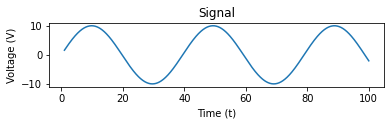

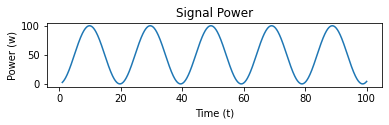

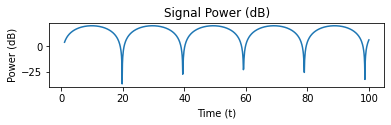

In [ ]:
t = np.linspace(1,100,1000)
v = 10*np.sin(t/(2*np.pi))

plt.subplot(3,1,1)
plt.plot(t,v)
plt.title("Signal")
plt.ylabel("Voltage (V)")
plt.xlabel("Time (t)")
plt.show()

w = v ** 2
plt.subplot(3,1,2)
plt.plot(t,w)
plt.title("Signal Power")
plt.ylabel("Power (w)")
plt.xlabel("Time (t)")
plt.show()

w_db = 10 * np.log10(w)
plt.subplot(3,1,3)
plt.plot(t,w_db)
plt.title("Signal Power (dB)")
plt.ylabel("Power (dB)")
plt.xlabel("Time (t)")
plt.show()

In [ ]:
target_snr_db = 20
# Calculate signal power and convert to dB 
sig_avg_watts = np.mean(w)
sig_avg_db = 10 * np.log10(sig_avg_watts)
# Calculate noise according to [2] then convert to watts
noise_avg_db = sig_avg_db - target_snr_db
noise_avg_watts = 10 ** (noise_avg_db / 10)
# Generate an sample of white noise
mean_noise = 0
noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(w))
# Noise up the original signal
y_volts = v + noise_volts

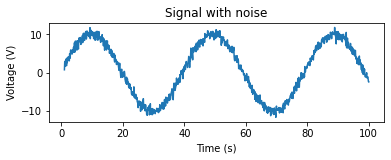

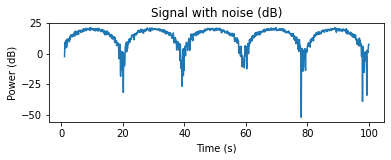

In [ ]:
plt.subplot(2,1,1)
plt.plot(t, y_volts)
plt.title('Signal with noise')
plt.ylabel('Voltage (V)')
plt.xlabel('Time (s)')
plt.show()
# Plot in dB
y_watts = y_volts ** 2
y_db = 10 * np.log10(y_watts)
plt.subplot(2,1,2)
plt.plot(t, 10* np.log10(y_volts**2))
plt.title('Signal with noise (dB)')
plt.ylabel('Power (dB)')
plt.xlabel('Time (s)')
plt.show()

In [ ]:
def signal_gen():
  l = np.random.randint(1, 100)
  t = np.linspace(1,l,1000)
  v = 10*np.sin(t/(2*np.pi)) / 1000
  return v


def noise_gen(v):
  w = v ** 2
  target_snr_db = 20
  sig_avg_watts = np.mean(w)
  sig_avg_db = 10 * np.log10(sig_avg_watts)
  noise_avg_db = sig_avg_db - target_snr_db
  noise_avg_watts = 10 ** (noise_avg_db / 10)
  mean_noise = 0
  noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(w))
  y_volts = v + noise_volts
  return y_volts



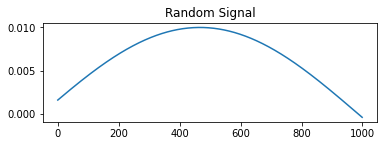

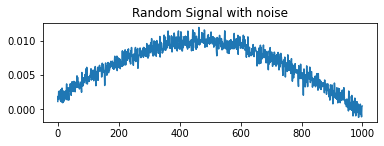

In [ ]:
v = signal_gen()

plt.subplot(2,1,1)
plt.title("Random Signal")
plt.plot( v)
plt.show()

plt.subplot(2,1,2)
plt.title("Random Signal with noise")
plt.plot(noise_gen(v))
plt.show()



In [ ]:
signal = []
noisy_signal = []

for i in range(1000):
  v = signal_gen()
  signal.append(v)
  noisy_signal.append(noise_gen(v))

In [ ]:
len(signal)

1000

In [ ]:
#signal[:1][0]

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class DeNoise(nn.Module):
  def __init__(self):
    super(DeNoise, self).__init__()
    
    self.lin1 = nn.Linear(1000, 800)
    self.lin_t1 = nn.Linear(800, 1000)


  def forward(self, x):
    x = F.tanh(self.lin1(x))
    x = self.lin_t1(x)
    return x

model = DeNoise().cuda()
print(model)

DeNoise(
  (lin1): Linear(in_features=1000, out_features=800, bias=True)
  (lin_t1): Linear(in_features=800, out_features=1000, bias=True)
)


In [ ]:
import torch

# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train(n_epochs , model):
  training_loss = []

  for epoch in range(n_epochs):
    trainloss = 0.0
    for sig, noisig in zip(signal, noisy_signal):

      sig = torch.Tensor(sig).cuda()
      noisig = torch.Tensor(noisig).cuda()

      optimizer.zero_grad()
      output = model(noisig)
      loss = criterion(output , sig) 
      loss.backward()
      optimizer.step()
      trainloss += loss.item()  
    print("Epoch: {} , Training Loss: {}".format(epoch + 1  , trainloss / len(signal)))
    training_loss.append(trainloss / len(signal))
  plt.plot(training_loss)
        
  print("Training Completed !!!")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch: 1 , Training Loss: 0.0002059952046062179
Epoch: 2 , Training Loss: 4.764753030492841e-07
Epoch: 3 , Training Loss: 1.506051995544766e-06
Epoch: 4 , Training Loss: 8.46175100083002e-07
Epoch: 5 , Training Loss: 1.466463045094457e-06
Epoch: 6 , Training Loss: 2.446729900686506e-06
Epoch: 7 , Training Loss: 6.537766632348507e-07
Epoch: 8 , Training Loss: 1.7491256445438807e-06
Epoch: 9 , Training Loss: 0.0006510985572921015
Epoch: 10 , Training Loss: 5.250076137492953e-07
Training Completed !!!


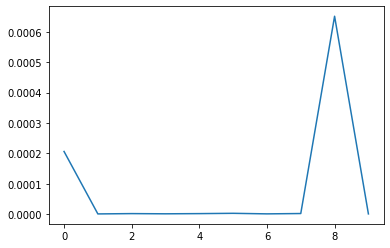

In [ ]:
train(10, model)

In [ ]:
def plot(i):

  pred = model(torch.Tensor(signal[i]).cuda()).cpu()
  plt.subplot(4,1,1)
  plt.title("Original Signal")
  plt.xlabel("Voltage")
  plt.ylabel("Time")
  plt.plot(signal[i])
  plt.show()

  plt.subplot(4,1,2)
  plt.title("Noisy Signal")
  plt.xlabel("Voltage")
  plt.ylabel("Time")
  plt.plot(noisy_signal[i])
  plt.show()

  plt.subplot(4,1,3)
  plt.title("Predicted Signal")
  plt.xlabel("Voltage")
  plt.ylabel("Time")
  plt.plot(pred.detach().numpy())
  plt.show()

  y_watts = pred.detach().numpy() ** 2
  y_db = 10 * np.log10(y_watts)

  plt.subplot(4,1,4)
  plt.title("Signal SnR")
  plt.xlabel("Power (dB)")
  plt.ylabel("Time")
  plt.plot(y_db)
  plt.show()

## Results

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


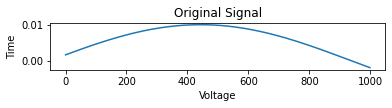

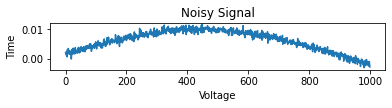

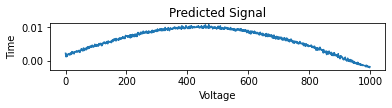

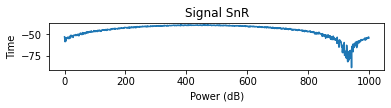

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


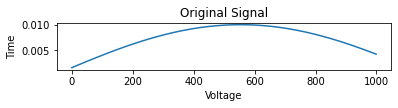

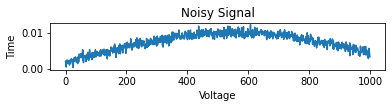

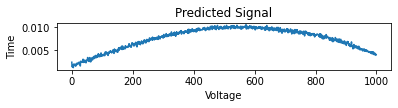

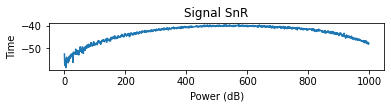

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


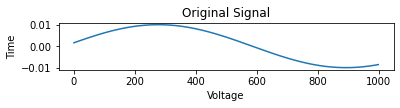

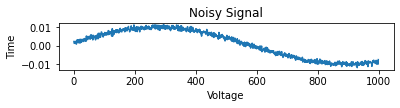

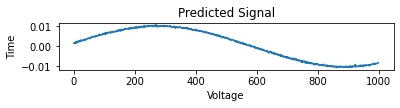

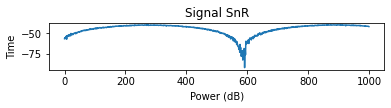

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


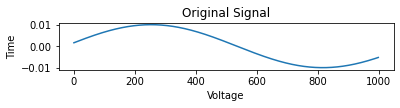

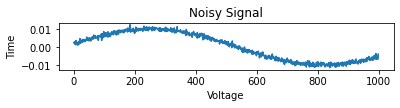

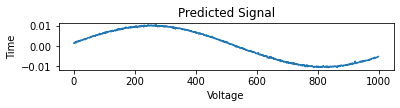

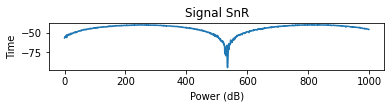

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


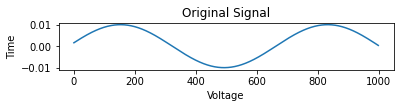

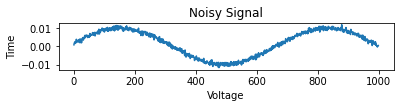

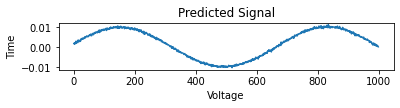

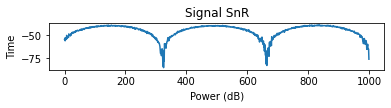

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


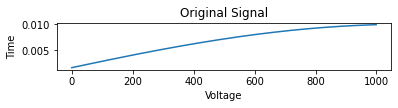

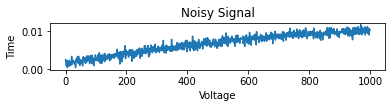

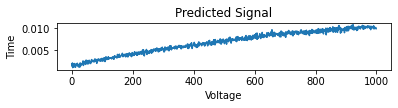

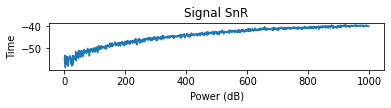

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


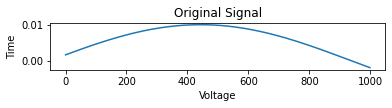

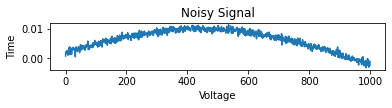

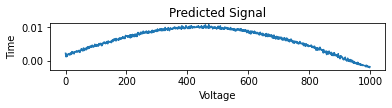

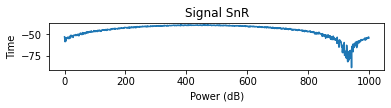

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


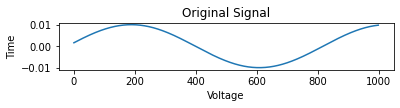

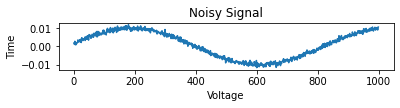

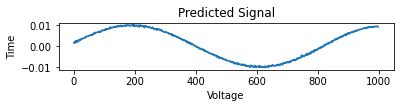

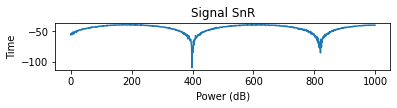

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


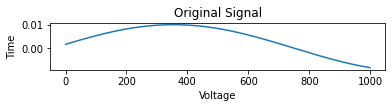

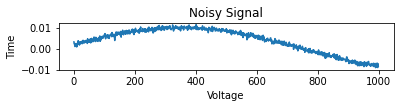

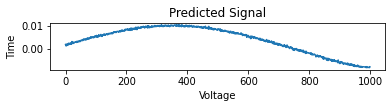

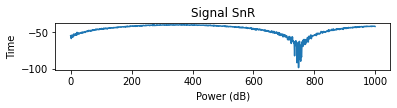

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


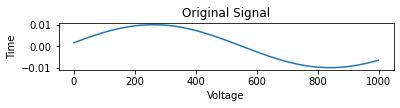

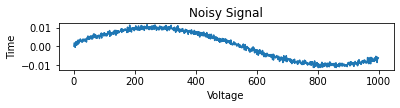

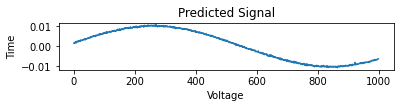

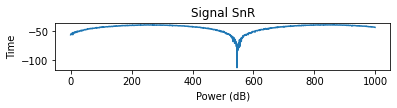

In [ ]:
for i in range(10):
  plot(i)